In [16]:
import torch
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_test,y_pred,labels=None,lenth=20,ratio=False,cmap="Blues",annot=True,width=12,fmt="g"):
    if labels == None:
        labels = pd.Series(labels for labels in y_test.squeeze()).unique()
    conf_mat = pd.DataFrame(confusion_matrix(y_test.squeeze(), y_pred.squeeze(), labels=labels))
    if ratio == True:
        conf_mat = conf_mat.divide(conf_mat.sum(axis=1), axis=0)
    fig, ax = plt.subplots(figsize=(lenth, width))
    sns.heatmap(conf_mat,cmap=cmap,annot=annot,xticklabels=labels,yticklabels=labels,fmt=fmt)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

In [17]:
f = open('char2idx.pkl','rb')
char2idx = pickle.load(f)
f.close()
f = open('idx2char.pkl','rb')
idx2char= pickle.load(f)
f.close()
f = open('char_df.pkl','rb')
char_df= pickle.load(f)
f.close()

In [18]:
EOS_NUM = 0
UNK_NUM = 1
PADDLING_NUM = 2

In [19]:
char_df['text'].apply(len).describe()

count    56821.000000
mean        19.011809
std          6.026609
min          0.000000
25%         15.000000
50%         19.000000
75%         23.000000
max        116.000000
Name: text, dtype: float64

In [20]:
def getWordEmbedding(data):
    seq_embed = []
    _ = 0
    for word in data:
        seq_embed.append(word)
        _ += 1
        if _ == 19:
            break
    if _ <= 19:
        for i in range(19 - _):
            seq_embed.append(PADDLING_NUM)
    seq_embed = np.array(seq_embed)
    return seq_embed

In [21]:
char_df['text'] = char_df['text'].apply(getWordEmbedding)

In [22]:
train_df = char_df[['text','class']]
train_df['class'] = train_df['class'].apply(np.float32)
X_train,X_test,y_train,y_test = train_test_split(
    train_df['text'].values,
    train_df['class'].values,
    test_size=0.2,
    stratify=train_df['class'],
    random_state=42,
)

C:\Users\Javon\AppData\Local\Temp/ipykernel_7872/531506816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class'] = train_df['class'].apply(np.float32)


In [23]:
class seqDataset(torch.utils.data.Dataset):
    def __init__(self,data,label,transformer = None):
        super(seqDataset,self).__init__()
        self.data = data
        self.label = label
        self.transformer = transformer
    
    def __getitem__(self,idx):
        if self.transformer:
            return transformer(self.data[idx]),self.label[idx]
        return self.data[idx],self.label[idx]
    
    def __len__(self):
        return len(self.data)

In [24]:
train_dataset = seqDataset(X_train,y_train)
test_dataset = seqDataset(X_test,y_test)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=500)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=500)

In [25]:
class SimpleRNN(nn.Module):
    def __init__(self,seq_len=19,embedding_size=256,h1_size=128,num_embeddings = len(idx2char)):
        super(SimpleRNN,self).__init__()
        self.embedding_size = embedding_size
        self.h1_size = h1_size
        self.seq_len = seq_len
        self.num_embeddings = num_embeddings

        self.embed = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)

        self.layer1 = nn.Sequential(
            nn.RNN(input_size = self.embedding_size,hidden_size = self.h1_size,num_layers=4,batch_first=True),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.h1_size,10),
            nn.Softmax(),
        )
    def forward(self,x):
        out = self.embed(x)
        out,hid = self.layer1(out)
        out = out[:,-1,:]
        out = self.output(out)
        return out

In [26]:
class SimpleLSTM(nn.Module):
    def __init__(self,seq_len=19,embedding_size=256,h1_size=128,num_embeddings = len(idx2char)):
        super(SimpleLSTM,self).__init__()
        self.embedding_size = embedding_size
        self.h1_size = h1_size
        self.seq_len = seq_len
        self.num_embeddings = num_embeddings

        self.embed = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)

        self.layer1 = nn.Sequential(
            nn.LSTM(input_size = self.embedding_size,hidden_size = self.h1_size,num_layers=4,batch_first=True),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.h1_size,10),
            nn.Softmax(),
        )
    def forward(self,x):
        out = self.embed(x)
        out,hid = self.layer1(out)
        out = out[:,-1,:]
        out = self.output(out)
        return out

In [27]:
def train(model,EPOCH=150,learning_rate=0.5):
    model = model
    opt = torch.optim.SGD(params=model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    EPOCH = EPOCH
    itr = 0
    model.cuda()
    for epoch in range(EPOCH):
        for i,(x,y) in enumerate(train_loader):
            batch_X = torch.LongTensor(np.int64(x)).cuda()
            batch_Y = torch.LongTensor(np.int64(y)).cuda()
            output = model(batch_X)
            opt.zero_grad()
            loss = loss_fn(output,batch_Y)
            loss.backward()
            opt.step()
            if (i+1) % 20 == 0:
                itr += 20
                acc = (batch_Y.detach().cpu().numpy() == output.detach().cpu().argmax(axis=1).numpy()).mean()
                print('epoch\t:{}\titr:{}\tloss:{}\tacc:{}\n'.format(epoch,itr,loss,acc))
                # print(output.detach().cpu())
    return model

def test(model):
    accs = []
    y_pred = []
    y_true = []
    for i,(x,y) in enumerate(test_loader):
        batch_X = torch.LongTensor(np.int64(x)).cuda()
        batch_Y = torch.LongTensor(np.int64(y)).cuda()
        output = model(batch_X)
        acc = (batch_Y.detach().cpu().numpy() == output.detach().cpu().argmax(axis=1).numpy()).mean()
        accs.append(acc)
        y_pred.extend(output.detach().cpu().argmax(axis=1).numpy())
        y_true.extend(batch_Y.detach().cpu().numpy()) 
    print(np.array(accs).mean())
    return y_pred,y_true

In [28]:
class SimpleCNN(nn.Module):
    def __init__(self,embedding_size=256,num_embeddings = len(idx2char)):
        super(SimpleCNN,self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_size = embedding_size
        self.embed = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels = 256,out_channels = 128,kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
        )
        #[batch_size = 500,channels=128,seq = 18]
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels = 128,out_channels = 128,kernel_size=2,stride = 2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
        )
        #[batch_size = 500,embedding_size = 128,seq = 9]
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels = 128,out_channels = 128,kernel_size=3,stride = 2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            # nn.MaxPool1d(6),
        )
        #[batch_size = 500,embedding_size = 256, seq = 4]
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels = 128,out_channels = 128,kernel_size = 4),
            nn.ReLU(),
            nn.BatchNorm1d(128),
        )
        self.shortcut = nn.Sequential(
            nn.Conv1d(in_channels = 256,out_channels = 128,kernel_size = 19),
        )
        #[batch_size = 500,embedding_size = 256,seq_len - k_s + 1 = 1]
        
        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128,10),
            nn.Softmax()
        )
    def forward(self,x):
        emb = self.embed(x).transpose(2,1)
        out = self.conv1(emb)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.shortcut(emb) + self.conv4(out)
        out = self.output(out)
        return out

In [29]:
class TransformerEncoder(nn.Module):
    def __init__(self,seq_len=19,embedding_size=256,num_embeddings = len(char2idx)):
        super(TransformerEncoder,self).__init__()
        self.num_embeddings = num_embeddings 
        self.embedding_size = embedding_size
        self.seq_len = seq_len
        self.emb = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)
        self.layer1 = nn.Sequential(
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.seq_len*self.embedding_size,self.embedding_size),
            nn.Sigmoid(),
            nn.Linear(self.embedding_size,10),
            nn.Softmax(),
        )
    def forward(self,x):
        out = self.emb(x)
        out = self.layer1(out)
        out = self.output(out)
        return out

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch	:0	itr:20	loss:2.2967658042907715	acc:0.136

epoch	:0	itr:40	loss:2.2867815494537354	acc:0.14

epoch	:0	itr:60	loss:2.278503656387329	acc:0.144

epoch	:0	itr:80	loss:2.268864154815674	acc:0.166

epoch	:1	itr:100	loss:2.272786855697632	acc:0.144

epoch	:1	itr:120	loss:2.2558810710906982	acc:0.184

epoch	:1	itr:140	loss:2.205277442932129	acc:0.242

epoch	:1	itr:160	loss:2.2097346782684326	acc:0.23

epoch	:2	itr:180	loss:2.2015433311462402	acc:0.244

epoch	:2	itr:200	loss:2.2049062252044678	acc:0.236

epoch	:2	itr:220	loss:2.2108399868011475	acc:0.246

epoch	:2	itr:240	loss:2.116234302520752	acc:0.344

epoch	:3	itr:260	loss:2.146712064743042	acc:0.318

epoch	:3	itr:280	loss:2.140983819961548	acc:0.322

epoch	:3	itr:300	loss:2.1097238063812256	acc:0.348

epoch	:3	itr:320	loss:2.0696823596954346	acc:0.388

epoch	:4	itr:340	loss:2.063750982284546	acc:0.402

epoch	:4	itr:360	loss:2.1084649562835693	acc:0.352

epoch	:4	itr:380	loss:2.080374002456665	acc:0.38

epoch	:4	itr:400	loss:2.0708

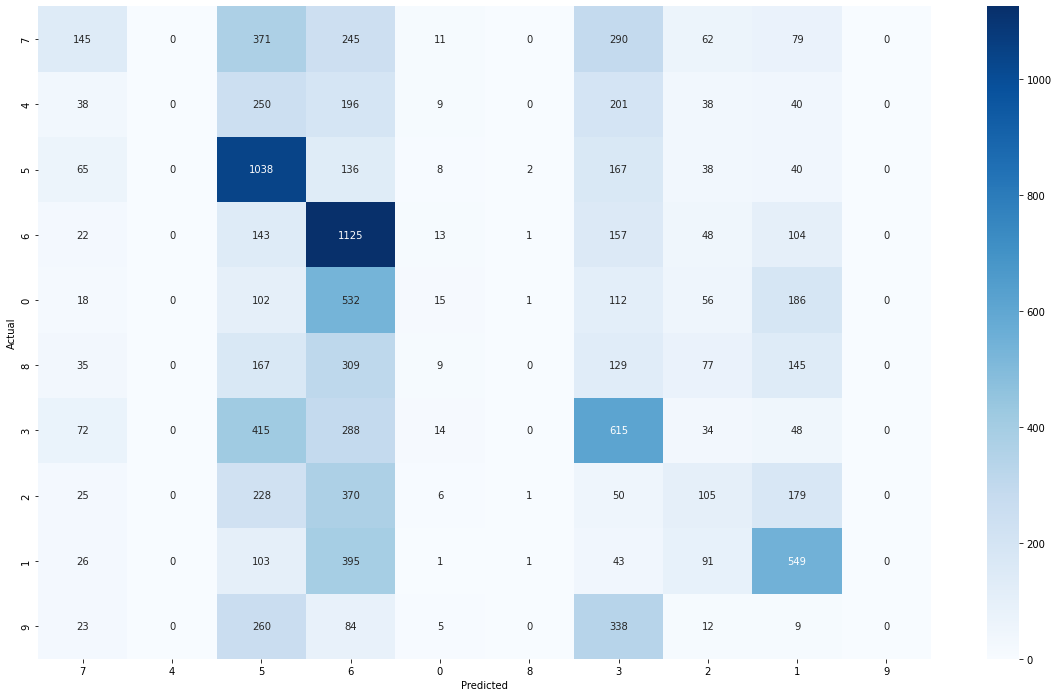

In [30]:
model = train(SimpleRNN(),EPOCH=500,learning_rate=0.5)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch	:0	itr:20	loss:2.1865735054016113	acc:0.286

epoch	:0	itr:40	loss:2.0534191131591797	acc:0.416

epoch	:0	itr:60	loss:1.9938504695892334	acc:0.48

epoch	:0	itr:80	loss:1.9177985191345215	acc:0.554

epoch	:1	itr:100	loss:1.8558132648468018	acc:0.618

epoch	:1	itr:120	loss:1.7999767065048218	acc:0.678

epoch	:1	itr:140	loss:1.819823145866394	acc:0.66

epoch	:1	itr:160	loss:1.7768256664276123	acc:0.692

epoch	:2	itr:180	loss:1.7376224994659424	acc:0.738

epoch	:2	itr:200	loss:1.7066391706466675	acc:0.768

epoch	:2	itr:220	loss:1.7359052896499634	acc:0.728

epoch	:2	itr:240	loss:1.701284646987915	acc:0.766

epoch	:3	itr:260	loss:1.6764214038848877	acc:0.786

epoch	:3	itr:280	loss:1.650105595588684	acc:0.826

epoch	:3	itr:300	loss:1.6793982982635498	acc:0.8

epoch	:3	itr:320	loss:1.6595299243927002	acc:0.806

epoch	:4	itr:340	loss:1.63031005859375	acc:0.83

epoch	:4	itr:360	loss:1.6224955320358276	acc:0.85

epoch	:4	itr:380	loss:1.6416229009628296	acc:0.826

epoch	:4	itr:400	loss:1.645

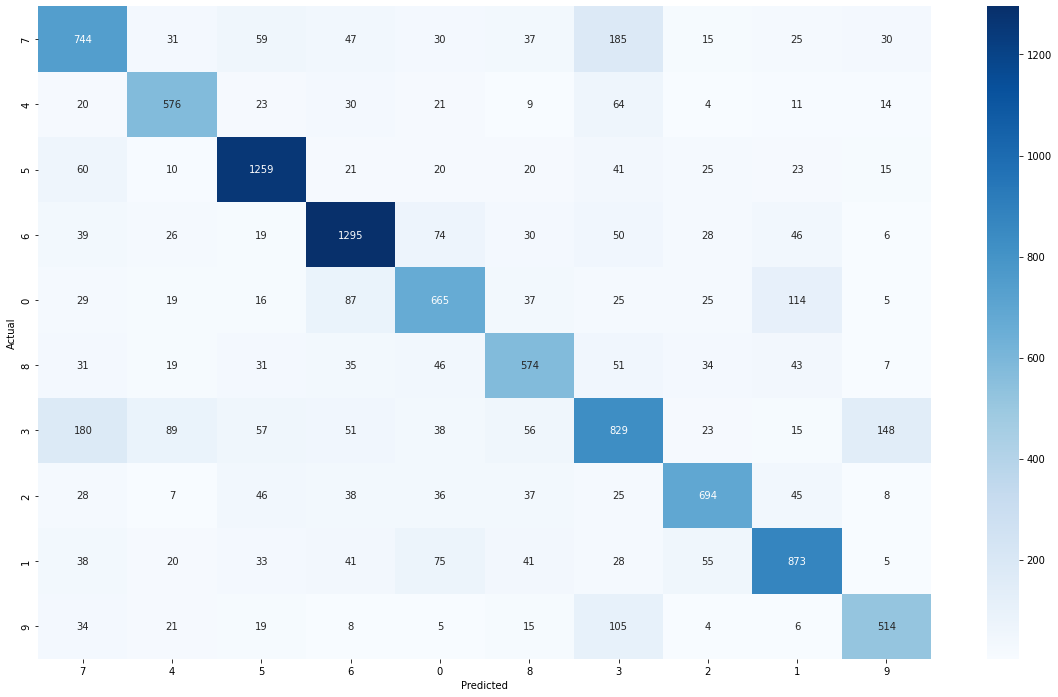

In [15]:
model = train(SimpleCNN(),EPOCH=500,learning_rate=0.5)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch	:0	itr:20	loss:2.301344871520996	acc:0.128

epoch	:0	itr:40	loss:2.300795555114746	acc:0.108

epoch	:0	itr:60	loss:2.2988650798797607	acc:0.148

epoch	:0	itr:80	loss:2.2973482608795166	acc:0.138

epoch	:1	itr:100	loss:2.2961483001708984	acc:0.138

epoch	:1	itr:120	loss:2.2966456413269043	acc:0.14

epoch	:1	itr:140	loss:2.2937400341033936	acc:0.134

epoch	:1	itr:160	loss:2.2911858558654785	acc:0.166

epoch	:2	itr:180	loss:2.290574550628662	acc:0.138

epoch	:2	itr:200	loss:2.2922446727752686	acc:0.14

epoch	:2	itr:220	loss:2.2883825302124023	acc:0.134

epoch	:2	itr:240	loss:2.2842113971710205	acc:0.166

epoch	:3	itr:260	loss:2.2849223613739014	acc:0.138

epoch	:3	itr:280	loss:2.2880594730377197	acc:0.14

epoch	:3	itr:300	loss:2.283651113510132	acc:0.134

epoch	:3	itr:320	loss:2.2779200077056885	acc:0.166

epoch	:4	itr:340	loss:2.2806501388549805	acc:0.138

epoch	:4	itr:360	loss:2.285449981689453	acc:0.14

epoch	:4	itr:380	loss:2.2803096771240234	acc:0.134

epoch	:4	itr:400	loss:2.2

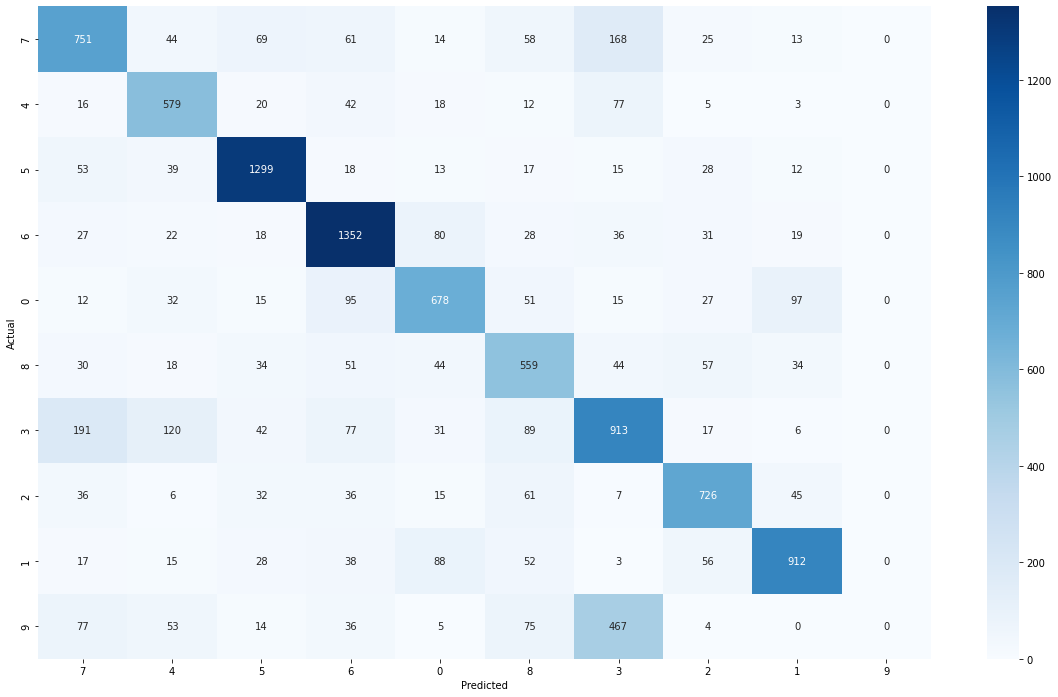

In [31]:
model = train(SimpleLSTM(),EPOCH=500,learning_rate=0.5)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch	:0	itr:20	loss:2.272862195968628	acc:0.138

epoch	:0	itr:40	loss:2.2689828872680664	acc:0.178

epoch	:0	itr:60	loss:2.272996664047241	acc:0.146

epoch	:0	itr:80	loss:2.2042105197906494	acc:0.244

epoch	:1	itr:100	loss:2.225095510482788	acc:0.228

epoch	:1	itr:120	loss:2.216674327850342	acc:0.22

epoch	:1	itr:140	loss:2.1525063514709473	acc:0.34

epoch	:1	itr:160	loss:2.1706366539001465	acc:0.278

epoch	:2	itr:180	loss:2.106518030166626	acc:0.36

epoch	:2	itr:200	loss:2.093024253845215	acc:0.362

epoch	:2	itr:220	loss:2.069950819015503	acc:0.396

epoch	:2	itr:240	loss:2.0382936000823975	acc:0.426

epoch	:3	itr:260	loss:2.057229995727539	acc:0.408

epoch	:3	itr:280	loss:2.049386739730835	acc:0.398

epoch	:3	itr:300	loss:2.0691521167755127	acc:0.382

epoch	:3	itr:320	loss:2.0256130695343018	acc:0.424

epoch	:4	itr:340	loss:2.0686142444610596	acc:0.388

epoch	:4	itr:360	loss:2.0270159244537354	acc:0.418

epoch	:4	itr:380	loss:2.017676830291748	acc:0.438

epoch	:4	itr:400	loss:1.99566

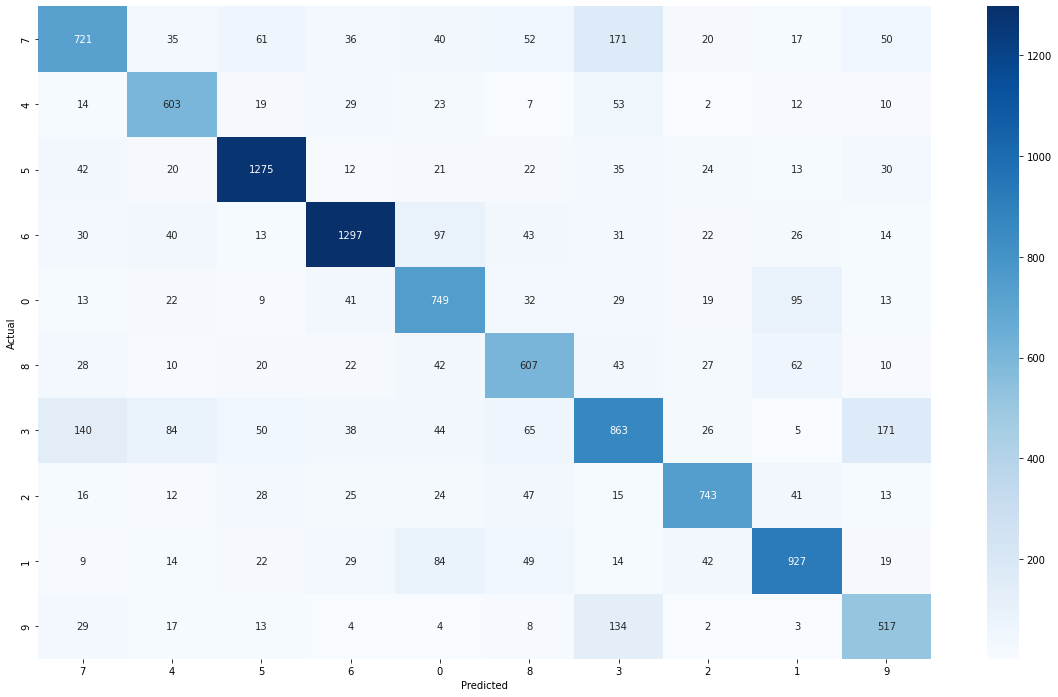

In [15]:
model = train(TransformerEncoder(),EPOCH=200,learning_rate=0.5)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))